In [325]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

Load data

In [326]:
from DataLoader import HeartFailureDataset

load_data = HeartFailureDataset()
X = load_data.get_features()
y = load_data.get_targets()
X.shape

(299, 12)

In [327]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280


We need to scale our data. Without scaling the data, the nerual network does not work! The gradients are too small!

In [328]:
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['creatinine_phosphokinase', 'platelets', 'serum_sodium']

scaler = StandardScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,0.000166,0,20,1,1.681648e-02,1.9,-1.504036,1,0,4
1,55.0,0,7.514640,0,38,0,7.535660e-09,1.1,-0.141976,1,0,6
2,65.0,0,-0.449939,0,20,0,-1.038073e+00,1.3,-1.731046,1,1,7
3,50.0,1,-0.486071,0,20,0,-5.464741e-01,1.9,0.085034,1,0,7
4,65.0,1,-0.435486,1,20,0,6.517986e-01,2.7,-4.682176,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,-0.537688,1,38,1,-1.109765e+00,1.1,1.447094,1,1,270
295,55.0,0,1.278215,0,38,0,6.802472e-02,1.2,0.539054,0,0,271
296,45.0,0,1.525979,1,60,0,4.902082e+00,0.8,0.312044,0,0,278
297,45.0,0,1.890398,0,38,0,-1.263389e+00,1.4,0.766064,1,1,280


### **Set up Logistic Regression model**
We want to set up our logistic regression by using a neural network. We will use one Linear Layer and the sigmoid function to transform our data in a range between 0 and 1.

In [329]:
torch.manual_seed(42)   # generate the same start solution every time

In [330]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_features = input_dimensions, out_features = 1)

    def forward(self,x): # Define forard function which applies sigmoid function to our output 
        return torch.sigmoid(self.linear(x))

In [331]:
LR_model = LogisticRegression(input_dimensions=X.shape[1])

So far, we will use the *binary cross-entropy-loss* (**BCELoss**). Later on, one can try different other loss functions.  
For a standard Logistic Regression without any regularization, we can use *Stochastic Gradient Descent* as an optimization tool.

## **TODO:** Test different learning rates and documetate number of epochs until convergence (or if there is convergence at all)

In [332]:
loss_fun = nn.BCELoss() 
learning_rate = 0.0001
optimizer = optim.SGD(LR_model.parameters(), lr=learning_rate)

### **Training step**

In [333]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

In [334]:
epochs = 500
plot_gradients = False

# We wish to save the trajectory of weight, bias and loss
hist_W = []
hist_b = []
hist_loss = []

#Trainigsloop bleibt auch bei mehrschichtigen Netzen gleich
for epoch in range(epochs):
    pred = LR_model(X_tensor)                       # Forward pass
    loss = loss_fun(pred, Y_tensor)                 # Compute loss

    optimizer.zero_grad()   # Gradienten auf Null setzen
    loss.backward()         # Berechne den Gradienten
    optimizer.step()        # Optimierungsschritt nach Gradient Descent 

    hist_loss.append(loss.item())

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
        if plot_gradients:
            for name, param in LR_model.named_parameters():
                if param.grad is not None:
                    print(f"Gradient of {name} : {param.grad}")

    


Epoch 0: Loss = 51.8458
Epoch 50: Loss = 0.6500
Epoch 100: Loss = 0.5610
Epoch 150: Loss = 0.5032
Epoch 200: Loss = 0.4707
Epoch 250: Loss = 0.4542
Epoch 300: Loss = 0.4459
Epoch 350: Loss = 0.4414
Epoch 400: Loss = 0.4385
Epoch 450: Loss = 0.4362


Visualize loss function for the training iterations. Test this one for different learning rates.

Text(0, 0.5, 'loss')

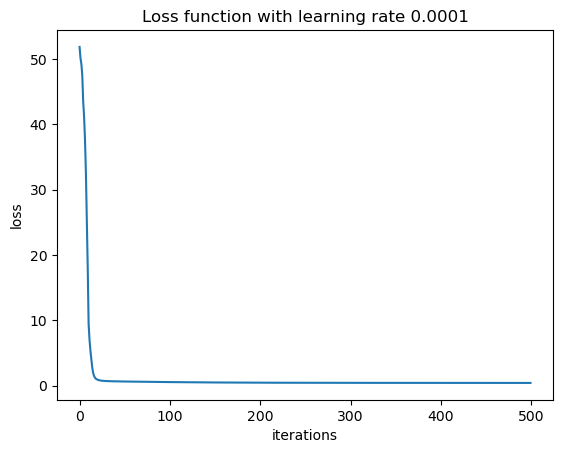

In [335]:
plt.plot(hist_loss)
plt.title(f"Loss function with learning rate {learning_rate}")
plt.xlabel("iterations")
plt.ylabel("loss")

In [336]:
for name, param in LR_model.named_parameters():
    print(f"Parameter: {name}")
    print(param.data)  

Parameter: linear.weight
tensor([[ 0.0910,  0.2383, -0.0657,  0.2646, -0.1229,  0.0571, -0.1409,  0.1704,
          0.2518, -0.2134,  0.2497, -0.0228]])
Parameter: linear.bias
tensor([0.2115])


## **Test different learning rates**

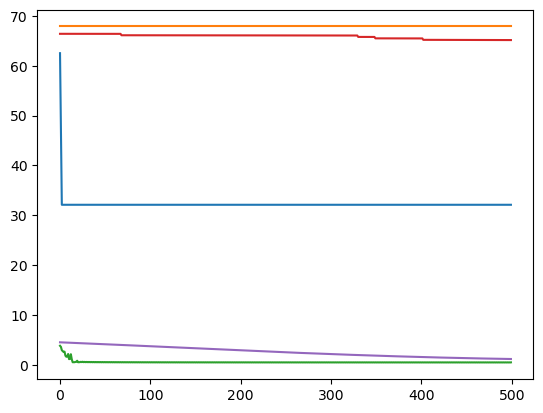

In [340]:
lr = [0.1, 0.01, 0.001, 0.0001, 0.00001]
losses = []

for learning_rate in lr:
    LR_model = LogisticRegression(input_dimensions=X.shape[1])

    loss_fun = nn.BCELoss() 
    optimizer = optim.SGD(LR_model.parameters(), lr=learning_rate)

    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    Y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    epochs = 500

    # We wish to save the trajectory of weight, bias and loss
    hist_W = []
    hist_b = []
    hist_loss = []

    #Trainigsloop bleibt auch bei mehrschichtigen Netzen gleich
    for epoch in range(epochs):
        pred = LR_model(X_tensor)                       # Forward pass
        loss = loss_fun(pred, Y_tensor)                 # Compute loss

        optimizer.zero_grad()   # Gradienten auf Null setzen
        loss.backward()         # Berechne den Gradienten
        optimizer.step()        # Optimierungsschritt nach Gradient Descent 

        hist_loss.append(loss.item())
    
    losses.append(hist_loss)

for hist_loss in losses:
    plt.plot(hist_loss)

## **TODO:** Validate model and try to regularize 